In [9]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime
from fund.fund import Fund
from pricer.pricer import Pricer as pricer_list
from ranker.ranker import Ranker as ranker_list
from classifier.classifier import Classifier as classifier_list
from portfolio.aportfolio import APortfolio
from parameters.parameters import Parameters as params
## analysis imports
from analysis.quarterly_analysis import QuarterlyAnalysis as quarterly_analysis
from analysis.weekly_analysis import WeeklyAnalysis as weekly_analysis

## risk and return class imports
from returns.products import Products as returns_products_class
from fund.fund import Fund

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [10]:
backtest_start_date = datetime(2003,1,1)
backtest_end_date  = datetime(2023,1,1)
current_start_date = datetime(2023,1,1)

In [11]:
market = Market()

In [12]:
portfolio = APortfolio(pricer_list.WEEKLY_STOCK_SPECULATION
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_ii = APortfolio(pricer_list.WEEKLY_STOCK_ROLLING
                           ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_iii = APortfolio(pricer_list.WEEKLY_STOCK_WINDOW
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_iv = APortfolio(pricer_list.WEEKLY_CRYPTO_ROLLING
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_v = APortfolio(pricer_list.WEEKLY_CRYPTO_WINDOW
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_vi = APortfolio(pricer_list.WEEKLY_CRYPTO_SPECULATION
                          ,classifier_list.NONE
                          ,ranker_list.NONE)

portfolios = []
portfolios.append(portfolio)
portfolios.append(portfolio_ii)
portfolios.append(portfolio_iii)
portfolios.append(portfolio_iv)
portfolios.append(portfolio_v)
portfolios.append(portfolio_vi)

In [13]:
fund = Fund(portfolios,backtest_start_date,backtest_end_date,current_start_date)
market = Market()
fund.initialize_portfolios()

In [14]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [15]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields"))
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()

In [16]:
analysis = []
parameters = params.parameters()
indexer = list(parameters[0].keys()) + ['portfolio']
indexer
for portfolio in tqdm(portfolios):
    portfolio.db.connect()
    for parameter in tqdm(parameters):
        try:
            trade = portfolio.db.query("trades",parameter)
            if trade.index.size > 0:
                indexer = list(parameters[0].keys()) + ['portfolio']
                positions = int(portfolio.pricer_class.positions / 5) if portfolio.pricer_class.asset_class.value == "stocks" else 1
                pricer_timeframe =  portfolio.pricer_class.time_horizon_class.naming_convention
                trade = trade[trade["position"] <= positions]
                ledger = trade.sort_values(["year",pricer_timeframe]).copy()
                anas = weekly_analysis if pricer_timeframe == "week" else quarterly_analysis
                if ledger.index.size > 0:
                    cumulative = anas.trade_analysis(ledger,positions,tyields,bench_returns)
                    for key in parameter.keys():
                        cumulative[key] = parameter[key]
                    cumulative["portfolio"] = portfolio.name
                    analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
        except Exception as e:
            print(str(e))
            continue
    portfolio.db.disconnect()
a = pd.DataFrame([x.to_dict() for x in analysis])

 57%|███████████████████████████████████████████████████████████████████████████████████▋                                                               | 41/72 [01:54<00:41,  1.33s/it]


 14%|████████████████████▍                                                                                                                              | 10/72 [01:36<14:43, 14.24s/it]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 53/72 [08:02<00:40,  2.11s/it]


 31%|████████████████████████████████████████████▉                                                                                                      | 22/72 [01:43<02:37,  3.14s/it]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 65/72 [03:16<00:10,  1.47s/it]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 49/72 [00:01<00:00, 37.65it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [14:36<00:00, 146.02s/it]


In [37]:
a[a["risk"]=="rrr"].sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,floor_value,tyields,portfolio,pv,beta,rrr,sharpe
119,True,True,False,False,False,1.15,1,15,rrr,1.0,tyields10,wsr_n_n_b_r,76.379021,0.005773,1.002728,13056.514851
117,True,True,False,False,False,1.15,1,15,rrr,1.0,tyields,wsr_n_n_b_r,76.379021,0.005773,1.002728,13056.514851
118,True,True,False,False,False,1.15,1,15,rrr,1.0,tyields2,wsr_n_n_b_r,76.379021,0.005773,1.002728,13056.514851
116,True,True,False,False,False,1.15,1,15,rrr,0.5,tyields10,wsr_n_n_b_r,55.575248,0.093302,1.038819,584.926916
115,True,True,False,False,False,1.15,1,15,rrr,0.5,tyields2,wsr_n_n_b_r,55.575248,0.093302,1.038819,584.926916
114,True,True,False,False,False,1.15,1,15,rrr,0.5,tyields,wsr_n_n_b_r,55.575248,0.093302,1.038819,584.926916
190,True,True,False,False,False,1.15,1,15,rrr,1.0,tyields2,wsw_n_n_b_r,38.812018,-0.022310,0.991185,-1694.851621
189,True,True,False,False,False,1.15,1,15,rrr,1.0,tyields,wsw_n_n_b_r,38.811790,0.006678,1.003101,5662.099509
191,True,True,False,False,False,1.15,1,15,rrr,1.0,tyields10,wsw_n_n_b_r,38.776192,-0.021629,0.991465,-1746.550949
187,True,True,False,False,False,1.15,1,15,rrr,0.5,tyields2,wsw_n_n_b_r,38.315147,-0.163996,0.932993,-227.534402


In [38]:
a[a["risk"]=="rrr"].sort_values("pv",ascending=False).groupby("portfolio").nth(0).reset_index()

,portfolio,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,floor_value,tyields,pv,beta,rrr,sharpe
0,wcr_n_n_b_r,True,True,False,False,False,1.15,1,20,rrr,0.5,tyields,1.372847,-0.854659,0.671044,-0.435845
1,wcs_n_n_b_r,True,True,False,False,False,1.15,1,5,rrr,1.0,tyields10,1.203754,1.840882,1.239082,0.110494
2,wcw_n_n_b_r,True,True,False,False,False,1.15,1,5,rrr,0.5,tyields,1.095457,0.210777,1.095508,0.451233
3,wsr_n_n_b_r,True,True,False,False,False,1.15,1,15,rrr,1.0,tyields10,76.379021,0.005773,1.002728,13056.514851
4,wss_n_n_b_r,True,True,False,False,False,1.15,1,15,rrr,0.5,tyields,26.930147,-0.096960,0.873306,-267.427129
5,wsw_n_n_b_r,True,True,False,False,False,1.15,1,15,rrr,1.0,tyields2,38.812018,-0.022310,0.991185,-1694.851621


In [19]:
top = a.sort_values("pv",ascending=False).iloc[0]
db = ADatabase(top["portfolio"])
parameter = top[[x for x in indexer if x != "portfolio"]].to_dict()
parameter
db.connect()
analysis = db.query("trades",parameter)
db.disconnect()

In [20]:
anas = weekly_analysis
naming = "week"
positions = int(int(analysis["position"].max())/5)
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[ledger["year"]>=backtest_start_date.year]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

In [21]:
ledger

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
0,2003,6,AMT,0.440700,1.0,0.959184,0,Real Estate,American Tower
1,2003,9,ALGN,0.333353,1.0,1.219947,0,Health Care,Align Technology
2,2003,12,ALGN,0.400009,1.0,1.204380,0,Health Care,Align Technology
3,2003,15,SBAC,0.427807,1.0,1.415254,0,Real Estate,SBA Communications
4,2003,18,SBAC,0.545718,1.0,1.588235,0,Real Estate,SBA Communications
...,...,...,...,...,...,...,...,...,...
31612,2023,9,EIX,0.069577,1.0,1.024166,99,Utilities,Edison International
31613,2023,12,GRMN,0.031371,1.0,1.009449,99,Consumer Discretionary,Garmin
31614,2023,15,HOLX,0.050485,1.0,1.005147,99,Health Care,Hologic
31615,2023,18,PPG,0.063469,1.0,0.980516,99,Materials,PPG Industries


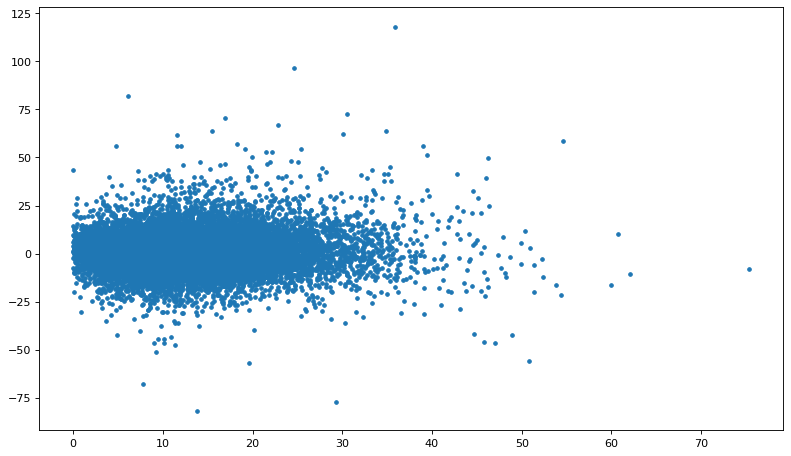

In [22]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [23]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(20)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
0,2003,6,AMT,0.440700,1.0,0.959184,0,Real Estate,American Tower
324,2003,6,SEE,0.304796,1.0,0.959883,1,Materials,Sealed Air
648,2003,6,GLW,0.265659,1.0,1.179104,2,Information Technology,Corning Inc.
972,2003,6,AES,0.263400,1.0,1.006079,3,Utilities,AES Corporation
1296,2003,6,TRMB,0.247665,1.0,1.000600,4,Information Technology,Trimble Inc.
1620,2003,6,ODFL,0.207662,1.0,0.863124,5,Industrials,Old Dominion
1944,2003,6,DISH,0.205638,1.0,1.034198,6,Communication Services,Dish Network
2268,2003,6,NFLX,0.202168,1.0,1.182927,7,Communication Services,Netflix
2592,2003,6,JNPR,0.201495,1.0,0.984901,8,Information Technology,Juniper Networks
2916,2003,6,ALGN,0.195579,1.0,1.453125,9,Health Care,Align Technology


In [24]:
ledger[ledger["position"]<20].sort_values("actual_returns",ascending=False).head(50)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
1303,2003,27,EQIX,0.359140,1.0,2.180573,4,Real Estate,Equinix
559,2017,45,ENPH,0.246270,1.0,1.965753,1,Information Technology,Enphase
1711,2008,42,AAL,0.061201,1.0,1.817690,5,Industrials,American Airlines Group
3195,2020,33,TSLA,0.304913,1.0,1.728221,9,Consumer Discretionary,"Tesla, Inc."
3803,2018,9,ENPH,0.169813,1.0,1.706093,11,Information Technology,Enphase
4540,2003,21,PWR,0.228799,1.0,1.666667,14,Industrials,Quanta Services
262,2019,30,ENPH,0.348794,1.0,1.637150,0,Information Technology,Enphase
811,2013,18,TSLA,0.300716,1.0,1.622337,2,Consumer Discretionary,"Tesla, Inc."
4,2003,18,SBAC,0.545718,1.0,1.588235,0,Real Estate,SBA Communications
98,2009,15,F,0.389874,1.0,1.561605,0,Consumer Discretionary,Ford Motor Company


In [25]:
ledger["actual_returns"].mean()

1.011535136708834

In [26]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.5776322864281873

In [27]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [28]:
positions

19

In [29]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [30]:
cumulative.head(10)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,year,week,pv,adjclose,bench,date_string,date
0,0.959184,0.959883,1.179104,1.006079,1.000600,0.863124,1.034198,1.182927,0.984901,1.453125,...,1.078053,1.008883,1.005538,2003,6,1.034962,854.137988,1.000000,2003-W6,2003-02-07
1,1.170153,1.023875,1.424438,1.247205,1.117453,1.104681,1.074827,1.234199,1.069858,2.012019,...,1.044205,1.023067,1.087550,2003,9,1.149799,845.392487,0.989761,2003-W9,2003-02-28
2,1.409308,1.101963,1.539595,1.195239,1.305907,1.235606,1.585370,1.223114,1.059471,2.049090,...,1.026402,1.057439,1.166916,2003,12,1.219571,815.514001,0.954780,2003-W12,2003-03-21
3,1.994529,1.255570,2.174834,1.578766,1.377256,1.396027,1.711684,1.536826,0.998667,2.080460,...,1.236467,1.113767,1.301859,2003,15,1.385748,868.571997,1.016899,2003-W15,2003-04-11
4,3.167782,1.345769,2.679512,2.172434,1.530500,1.331736,2.030905,1.496183,1.540232,2.853397,...,1.231055,1.054366,1.292586,2003,18,1.598704,906.528003,1.061337,2003-W18,2003-05-02
5,3.496293,1.732135,2.882836,2.556832,2.311837,1.838099,2.125422,1.913929,1.671716,3.261943,...,1.361215,1.148667,1.974131,2003,21,1.894409,943.531995,1.104660,2003-W21,2003-05-23
6,3.404285,1.698693,2.672629,2.314539,2.414051,1.504989,1.963258,1.729285,2.162616,3.331770,...,1.360259,1.095398,2.390776,2003,24,1.841037,980.540003,1.147988,2003-W24,2003-06-13
7,3.594681,2.025806,2.520961,2.353548,5.264014,1.757322,2.218355,1.853824,1.810882,3.199320,...,1.314999,1.068610,2.548204,2003,27,2.034567,980.490002,1.147929,2003-W27,2003-07-04
8,3.692622,2.013675,1.991707,2.332073,5.903840,1.760732,1.601074,1.403031,1.742639,4.311376,...,1.293442,0.910984,2.486111,2003,30,2.028609,994.683996,1.164547,2003-W30,2003-07-25
9,4.902319,1.977284,2.340333,2.551685,5.960365,1.881813,1.628936,1.514062,1.888433,5.120334,...,1.233636,0.940872,2.544462,2003,33,2.216464,973.414014,1.139645,2003-W33,2003-08-15


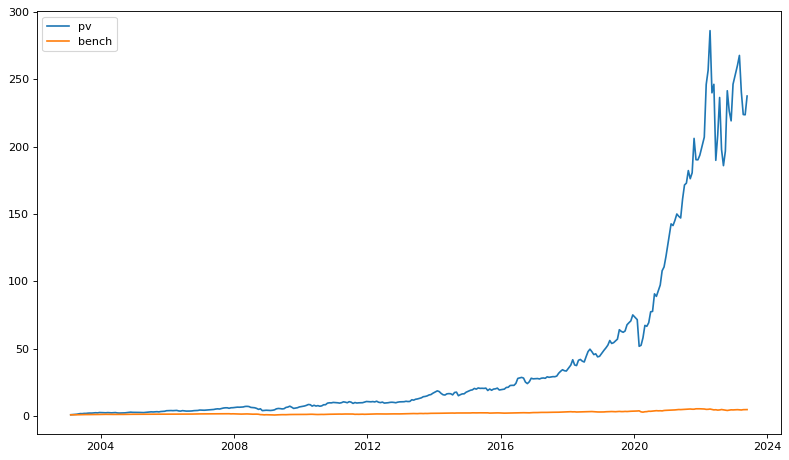

In [31]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [32]:
cumulative.tail(20)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,year,week,pv,adjclose,bench,date_string,date
304,131.583910,34.137909,201.889922,49.405266,108.028139,25.389183,3882.585143,13.520801,11.523743,24.408135,...,64.591231,80.934523,2.631589,2022,12,256.722126,4333.64,5.073700,2022-W12,2022-03-25
305,117.009964,35.540600,187.569010,47.593031,97.677425,24.342317,4484.748507,14.251655,11.325133,26.233200,...,64.048544,73.980622,2.552159,2022,15,286.096444,4515.48,5.286593,2022-W15,2022-04-15
306,120.692639,39.038265,137.251234,50.017568,83.809909,25.716026,3661.247762,14.620348,12.148831,26.192961,...,68.624335,72.808222,2.385347,2022,18,239.949058,4214.94,4.934730,2022-W18,2022-05-06
307,112.031087,40.323721,129.125624,49.480349,83.780062,26.138900,3829.957254,12.482030,12.211891,26.147554,...,61.373962,68.228912,2.096953,2022,21,246.260118,3964.54,4.641569,2022-W21,2022-05-27
308,89.072043,34.192856,104.927933,39.221243,63.698483,21.750125,2873.300540,9.464492,10.920811,20.405218,...,52.571716,71.970197,2.416075,2022,24,189.846351,4063.31,4.757206,2022-W24,2022-06-17
309,90.264462,35.008081,104.687748,34.356376,63.530960,21.689963,3224.052373,9.136707,10.761667,21.240549,...,52.742062,75.383636,2.378438,2022,27,208.585476,3830.24,4.484334,2022-W27,2022-07-08
310,122.360349,38.618893,112.297350,32.256726,61.139191,22.641679,3663.475675,9.140363,10.825938,21.273894,...,75.355425,80.558908,2.475289,2022,30,236.493016,3937.60,4.610028,2022-W30,2022-07-29
311,132.121943,36.011794,114.366711,28.939156,60.788654,20.026679,2944.995716,7.869334,10.954047,18.897611,...,73.864735,79.123385,2.394907,2022,33,197.930918,4192.04,4.907919,2022-W33,2022-08-19
312,128.507788,36.760398,108.937131,25.245950,51.897876,18.651846,2772.790813,7.431843,10.203697,14.974753,...,70.100179,74.884319,2.460375,2022,36,185.903360,3972.58,4.650982,2022-W36,2022-09-09
313,132.395007,32.450754,98.323166,27.143032,53.966294,17.406222,2976.708840,6.318630,10.316735,16.407439,...,74.361048,80.169076,2.658841,2022,39,196.721942,3799.39,4.448216,2022-W39,2022-09-30


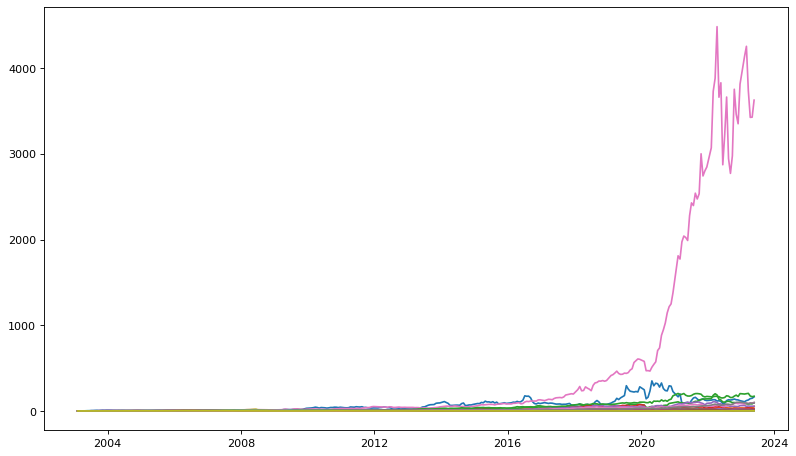

In [33]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)
plt.show()


In [34]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,week,weekly_delta,weekly_delta_sign,actual_returns,position
GICS Sector,,,,,,
Information Technology,2013.174977,28.513068,0.131264,1.0,1.015619,45.104912
Consumer Discretionary,2012.694201,28.934945,0.129315,1.0,1.015260,44.441472
Materials,2012.603264,28.094162,0.125652,1.0,1.014541,47.588198
Communication Services,2013.522207,27.296770,0.128806,1.0,1.011605,44.274563
Industrials,2012.565118,28.781186,0.116417,1.0,1.010421,53.437400
Real Estate,2011.039236,27.487868,0.106681,1.0,1.010279,56.562726
Energy,2012.960712,26.499079,0.130353,1.0,1.010255,40.591774
Health Care,2012.645310,27.750173,0.118929,1.0,1.009408,46.826227
Financials,2012.877079,28.626617,0.117578,1.0,1.009331,56.377696


In [35]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

weekly_delta  weekly_delta_sign  \
year week ticker Security                                                    
2003 27   EQIX   Equinix                       0.359140                1.0   
2017 45   ENPH   Enphase                       0.246270                1.0   
2008 42   AAL    American Airlines Group       0.061201                1.0   
2020 33   TSLA   Tesla, Inc.                   0.304913                1.0   
2018 9    ENPH   Enphase                       0.169813                1.0   
2003 21   PWR    Quanta Services               0.228799                1.0   
     42   AKAM   Akamai                        0.155379                1.0   
2019 30   ENPH   Enphase                       0.348794                1.0   
2013 18   TSLA   Tesla, Inc.                   0.300716                1.0   
2020 39   SEDG   SolarEdge                     0.116242                1.0   
2003 18   SBAC   SBA Communications            0.545718                1.0   
2010 51   NVDA   Nvidia                        0.182732                1.0   
2018 24   ENPH   Enphase                       0.115952                1.0   
2009 15   F      Ford Motor Company            0.389874                1.0   
2014 45   PAYC   Paycom                        0.120257                1.0   
2020 18   ENPH   Enphase                       0.048069                1.0   
2011 6    IPGP   IPG Photonics                 0.191774                1.0   
2003 18   BKNG   Booking Holdings              0.253650                1.0   
2009 36   UAL    United Airlines Holdings      0.221705                1.0   
2003 21   EQIX   Equinix                       0.214476                1.0   
          AKAM   Akamai                        0.393929                1.0   
2009 15   CBRE   CBRE Group                    0.199118                1.0   
2020 18   MRNA   Moderna                       0.461912                1.0   
2019 18   ENPH   Enphase                       0.242709                1.0   
2020 39   ENPH   Enphase                       0.141221                1.0   
2003 12   SBAC   SBA Communications            0.219899                1.0   
2020 27   TSLA   Tesla, Inc.                   0.250652                1.0   
2004 18   MNST   Monster Beverage              0.215932                1.0   
2009 30   PARA   Paramount Global              0.169116                1.0   
     18   EXPE   Expedia Group                 0.164218                1.0   

                                           actual_returns  position  
year week ticker Security                                            
2003 27   EQIX   Equinix                         2.180573         4  
2017 45   ENPH   Enphase                         1.965753         1  
2008 42   AAL    American Airlines Group         1.817690         5  
2020 33   TSLA   Tesla, Inc.                     1.728221         9  
2018 9    ENPH   Enphase                         1.706093        11  
2003 21   PWR    Quanta Services                 1.666667        14  
     42   AKAM   Akamai                          1.638261        46  
2019 30   ENPH   Enphase                         1.637150         0  
2013 18   TSLA   Tesla, Inc.                     1.622337         2  
2020 39   SEDG   SolarEdge                       1.617981        47  
2003 18   SBAC   SBA Communications              1.588235         0  
2010 51   NVDA   Nvidia                          1.570444        27  
2018 24   ENPH   Enphase                         1.562222        42  
2009 15   F      Ford Motor Company              1.561605         0  
2014 45   PAYC   Paycom                          1.561196        31  
2020 18   ENPH   Enphase                         1.559070        79  
2011 6    IPGP   IPG Photonics                   1.544678        13  
2003 18   BKNG   Booking Holdings                1.542289         8  
2009 36   UAL    United Airlines Holdings        1.528546        33  
2003 21   EQIX   Equinix                         1.527273        18  
      

In [36]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2003,6,1.017675,1.004591,0.894340,1.065501,0.986214,1.020720,0.957076,0.982551,0.950277,1.028086,0.988918
1,4012009,54,1.184451,1.073088,0.924641,1.077282,0.983609,1.090006,1.005345,1.031973,0.980980,1.091344,1.022436
2,8036054027,648,1.216826,1.112620,0.935705,1.084857,1.016918,1.049937,1.031646,0.969224,1.018496,1.175385,1.090918
3,16096216216081,9720,1.302445,1.192114,0.952137,1.169440,1.093357,1.077441,1.066247,1.058990,1.037851,1.248804,1.198312
4,32240721080810243,174960,1.287849,1.243473,0.910851,1.253452,1.105197,1.125167,1.051277,1.119256,1.032392,1.427190,1.288329
...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,0,0,69.241095,55.802063,7.487911,12.168997,12.330354,16.577404,28.593089,90.091725,43.633771,14.707004,5.707573
320,0,0,70.260743,55.802313,7.762316,12.352068,12.152262,16.946091,29.124978,90.326513,45.420159,15.148233,6.052318
321,0,0,68.268042,58.363187,8.154184,10.929884,11.615014,16.952067,29.783314,88.192286,45.031273,13.871746,6.048538
322,0,0,67.456253,54.737717,7.893020,10.929884,11.292312,16.250464,29.566751,92.449250,43.504355,13.644924,5.721945
